# Automatic delineation of field boundaries on satellite images

```
TODO: Add intro
```

In [1]:
# Mount google drive folder
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import numpy as np
import sys
import typing
import gdal
import keras
import tensorflow as tf

from skimage import exposure

# Install keras-unet library for python
#%pip uninstall keras-unet
%pip install git+https://github.com/karolzak/keras-unet

# define dataset directory
from google.colab import drive

BASE_PATH = "/content/drive/My Drive/Minor: EO Project Group 3"
INPUT_PATH = BASE_PATH + "/Classified Data/"
OUTPUT_PATH = BASE_PATH + "/Networks"
IMAGE_PATH = "/Original"
LABEL_PATH = "/Classified"

#INCLUDE_FOLDERS = ["Flevoland", "Friesland", "Gelderland", "Limburg", "Overijssel", "Zeeland", "Zuid-Holland"]
INCLUDE_FOLDERS = ["Flevoland"]


LEGEND = {
    1: 'Other',
    2: 'Field Boundary'
}



  Cloning https://github.com/karolzak/keras-unet to /tmp/pip-req-build-v1tmnkxk
  Running command git clone -q https://github.com/karolzak/keras-unet /tmp/pip-req-build-v1tmnkxk
  Created wheel for keras-unet: filename=keras_unet-0.1.2-cp36-none-any.whl size=16994 sha256=766e2b8c37be41678f0b866af6d73a06d4f9124c0f15c15f1c1cd18ace06b1c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-7jjed9nl/wheels/b3/3a/85/c3df1c96b5d83dcd2c09b634e72a98cafcf12a52501ac5cd77
Successfully built keras-unet


In [ ]:
# ################################################################
# Loading input data
#
# Input data is loaded into two dictionaries: 
#
# images: contains the 4-band images. The values are loaded as ints.
# labels: contains 3D arrays in which each pixel is assigned with 
#         a label "1" = other and "2" = field boundary
#
# ################################################################


def key_generator(file_name):
    """Generates the key of a file based on the file name. The resulting key is
    a tuple of the province as string & the file number index as int,
    e.g. ("gelderland", 29)
    """
    file_name = file_name.lower()
    file_name = file_name.replace("classified_", "")
    file_name = file_name.replace("original_", "")
    file_name = file_name.replace(".tif", "")
    # TODO: Some images are named incorrectly
    #       (e.g. no '_' between the province name and the image index)
    (province, index) = tuple(file_name.split("_"))
    index = int(index)
    return (province, index)

def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)

def transform_classification_image(input):
    """Takes the classification image input (in RGB format as 3D array) and 
    creates a 2D array out of this. The innermost array expects either values of
    [0, 0, 0] of [255, 255, 255] since this is the colouring we assigned to the
    classified images.

    :param input: 3D input image (classification)
    :return: 2D array image with labels 1 for 'other' and 2 for 'field_boundaries'
    """

    # Out of the 3D input array it takes the "max" element out of the array
    # This will either be 0 or 255. This function is just called to transform 
    # the 3D array to a 2D array.
    result = np.reshape(np.max(input, axis=2), (input.shape[0], input.shape[1], 1))

    # Now the array consists of pixels with values "0" or "255". We transform
    # each value, that is larger than 0 (i.e. 255) and assign the label "2" to
    # it. Each other element (i.e. 0) will get assigned the label "1".
    result = np.where(result > 0, 2, 1)
    return result

# Dictionaries which contain the input data
images = {}
labels = {}

# Iterate through defined folders and load all image data into the dictionaries
# image_data and label_data. Images can be accessed with (<province>, <index>)
for folder in INCLUDE_FOLDERS:
    original = INPUT_PATH + folder + IMAGE_PATH
    classified = INPUT_PATH + folder + LABEL_PATH
    for f in os.listdir(original): 
        value = gtiff_to_array(original + "/" + f)
        key = key_generator(f)
        images[key] = value
    for f in os.listdir(classified): 
        value = gtiff_to_array(classified + "/" + f) 

        # Transform the classification image from RGB to labels "1" and "2"
        value = transform_classification_image(value)
        key = key_generator(f)
        labels[key] = value

    print(f"{folder} image tiles: {len(os.listdir(original))}")
    print(f"{folder} label tiles: {len(os.listdir(classified))}")


print(f"Shape of sample image file: {list(images.values())[0].shape}")
print(f"Shape of sample label file: {list(labels.values())[0].shape}")

print(f"Total number of image & label tiles: {len(images)}")


Flevoland image tiles: 19
Flevoland label tiles: 19
Shape of sample image file: (800, 800, 4)
Shape of sample label file: (800, 800, 1)
Total number of image & label tiles: 19


In [ ]:

# ################################################################
# Normalizing images
# 
# Normalizing all input images into values in the interval [0, 1].
# All bands are normalized seperately, which means, the min & max
# of each band is calculated based on each band of the image data.
# ################################################################

def normalize(val, min, max):
    """Normalizes the value of a single pixel. Takes into account the minimum,
    and maximum value.

    v_normalized = (v - min) / (max - min)

    :param val: integer value
    :param min: integer minimum
    :param max: integer maximum
    :return: single floating point number in [0, 1]
    """
    # TODO: check if necessary, otherwise delete
    return (val - min) / (max - min)


def normalize_array(arr):
    """Takes a 3D array as input, iterates over the bands and normalizes those.

    :param arr: input array (original image data) 
    :return: normalized data with values between 0 and 1
    """
    arr_norm = np.zeros(arr.shape, dtype=np.float32)

    for i in range(arr.shape[2]):
        min = arr[:, :, i].min()
        max = arr[:, :, i].max()

        arr_norm = (arr - min) / (max - min)
    
    return arr_norm


for k, v in images.items():
    images[k] = normalize_array(v)
    print(f"Performed normalization of {k[0]}_{k[1]}")


Performed normalization of flevoland_21
Performed normalization of flevoland_22
Performed normalization of flevoland_20
Performed normalization of flevoland_34
Performed normalization of flevoland_36
Performed normalization of flevoland_37
Performed normalization of flevoland_50
Performed normalization of flevoland_52
Performed normalization of flevoland_51
Performed normalization of flevoland_66
Performed normalization of flevoland_64
Performed normalization of flevoland_65
Performed normalization of flevoland_79
Performed normalization of flevoland_80
Performed normalization of flevoland_95
Performed normalization of flevoland_93
Performed normalization of flevoland_94
Performed normalization of flevoland_107
Performed normalization of flevoland_108


In [ ]:
# ################################################################
# Split input data into training & test set
#
# Takes the entire input and splits the data into a training data
# set and test data set. The proportions are defined as follows:
#
#     Size_training = Size_input * RELATIVE_TRAINING_SIZE
#     Size_test = Size_input * (1 - RELATIVE_TRAINING_SIZE)
#
# The resulting data sets are mutually exclusive, e.g.:
#     Set_training | Set_test = Set_input
#     Set_training & Set_test = []
#
#     Remark: (| = Union, & = Intersection, [] = empty set)
#
# ################################################################

import random

# Constants to sample test & training set
SEED = 34
RELATIVE_TRAINING_SIZE = 0.9

def calculate_k(n):
    """Splitting the input data into training & test requires a variable called
    'k'. 'k' defines the size of the subset of a variable.

    :param n: Size of which k has to be calculated from
    :return: k
    """
    k = RELATIVE_TRAINING_SIZE * n
    return int(k)

# Create a generator with predefined SEED
random_generator = random.Random(SEED)

# Entire set of keys
keys = set(images.keys())

# Split key_set into x_train_keys and x_test_keys
keys_train = set(random_generator.sample(keys, calculate_k(len(keys))))
keys_test = keys - keys_train

# Generate dictionaries with training data
x_train_dict = { k : images[k] for k in keys_train }
y_train_dict = { k : labels[k] for k in keys_train }

# Generate dictionaries with test data
x_test_dict = { k : images[k] for k in keys_test }
y_test_dict = { k : labels[k] for k in keys_test }


# Print key set of each set
print(x_train_dict.keys())
print(x_test_dict.keys())


dict_keys([('flevoland', 34), ('flevoland', 66), ('flevoland', 22), ('flevoland', 107), ('flevoland', 64), ('flevoland', 21), ('flevoland', 95), ('flevoland', 52), ('flevoland', 20), ('flevoland', 94), ('flevoland', 51), ('flevoland', 93), ('flevoland', 50), ('flevoland', 80), ('flevoland', 37), ('flevoland', 79), ('flevoland', 36)])
dict_keys([('flevoland', 65), ('flevoland', 108)])


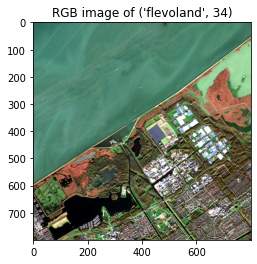

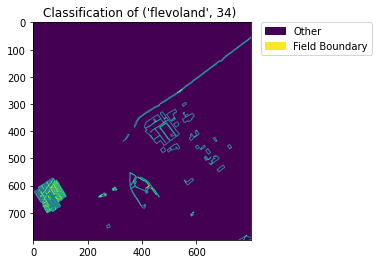

In [ ]:
# ################################################################
# Visualize some sample input data
#
# Helps to verify that the data is correct and also supports the
# thinking process if trying to debug the program.
# ################################################################

from matplotlib import patches, pyplot


def visualize_labels(arr, title, legend_labels):
    """Visualize the labels prepared from the reference images.
    
    :param arr: 3D array of an image to display
    :param title: Title to assign to the output
    :param label: Labels to use in the legend
    """
    fig = pyplot.figure()

    a = fig.add_subplot(1, 1, 1)
    a.set_title(title)

    values = np.unique(arr.ravel())
    im = pyplot.imshow(arr[:, :, 0])

    # get the colors of the values according to the color map used by imshow
    colors = [im.cmap(im.norm(v)) for v in values]

    # Generate a legend
    legend = []
    for i, v in enumerate(values):
        legend.append(patches.Patch(
            color=colors[i],
            label=legend_labels[v]
        ))
    pyplot.legend(handles=legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def visualize_data(arr, title):
    """Visualize the satellite image data.
    
    :param arr: Input image (4 bands, the first 3 will be printed)
    :param title: Title of the plot
    """
    # Switching bands:
    #     blue green red
    #     red  green blue

    data = arr[:, :, 0:-1]
    red = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = red

    # Should be already the case if normalization is included
    data = data.astype(np.float32)

    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = pyplot.figure()
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    pyplot.imshow(data)


key = list(x_train_dict.keys())[0]
#key = ('Overijssel', 17)
visualize_data(images[key], f"RGB image of {key}")
visualize_labels(labels[key], f"Classification of {key} ", LEGEND)


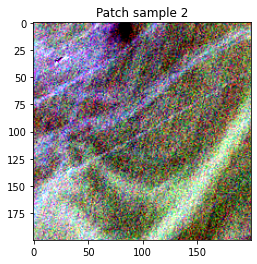

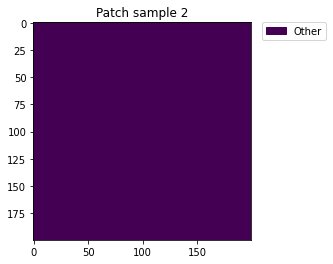

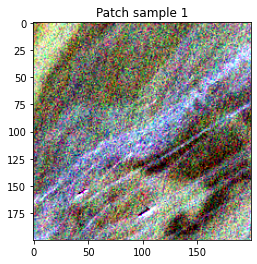

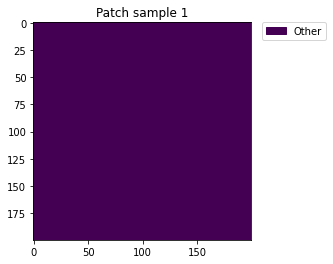

In [ ]:
# ################################################################
# Generating patches of the input data
#
# A convolutional neural network can be trained more efficiently,
# if the patches that are fed to the network are smaller. Thus,
# this section will cut a large input image (800x800px) into
# patches of a smaller size (compare PATCHSIZE)
# ################################################################

# Should be 80 for FCN-DK6, otherwise 50 for FCN-DK5 and less layers
# In the case of U-Net the patch size should be way larger in order to allow it
# to use the predefined layers.
PATCHSIZE = 200
NBANDS = list(images.values())[0].shape[-1]

def perform_gridwise_sampling(img, patchsize):
    """Takes an input array with 3 dimensions and returns a 4 dimension array
    where the outermost dimension consists of patches out of the image.
    Patches are cut gridwise out of a grid with patchsize x patchsize pixels

    :param img: 3D input array of an image
    :param patchsize: The size of a patch
    :return: input image split into multiple patches in 4D array
    """
    x = int(img.shape[0] / patchsize)
    y = int(img.shape[1] / patchsize)
    n = img.shape[2]
    s = patchsize # to keep the code lines short

    patches = np.zeros(
        shape=(0, s, s, n),
        dtype=img.dtype
    )

    for row in range(x):
        for col in range(y):
            # create patch, expand the dimension and add it to the samples
            patch = img[row * s : (row + 1) * s, col * s : (col + 1) * s, :]
            patch = np.expand_dims(patch, axis=0)
            patches = np.concatenate((patches, patch), axis=0)

    return patches


x_train = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
y_train = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.int)


for k in x_train_dict.keys():
    # Create patches
    x_patches = perform_gridwise_sampling(x_train_dict[k], PATCHSIZE)
    y_patches = perform_gridwise_sampling(y_train_dict[k], PATCHSIZE)

    # Insert patches into x_train and y_train data set
    x_train = np.concatenate((x_train, x_patches), axis=0)
    y_train = np.concatenate((y_train, y_patches), axis=0)


# Print a sample set of the data set to verify, samples are created properly
sample_size = 2

while sample_size:
    visualize_data(x_train[sample_size], f"Patch sample {sample_size}")
    visualize_labels(y_train[sample_size], f"Patch sample {sample_size}", LEGEND)
    sample_size -= 1


# Setting up the network



In [ ]:
# ################################################################
# Prerequisites for the network
#
# Includes a few helper functions which will be used to create and
# evaluate the network, the training and the accuracy.
# ################################################################

import imp, h5py
import dill, pickle
imp.reload(h5py)

import tensorflow as tf

from tensorflow.python.keras import backend as K
sess = K.get_session()

from tensorflow.compat.v1.keras.backend import set_session


# Tensorflow configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))



# Helper functions for the networks

def to_categorical_4d(y: np.ndarray, nc: int):
    """Convert a reclassed ground truth array to one-hot encoding

    Data structure is as follows:

    4D array, consisting of the different patches, rows, columns of pixels.
    The innermost array has as many elements as labels/classes exist.
    Each element in the array represents a class, e.g:
        label[x, y, z, 0] = label 1
        label[x, y, z, 1] = label 2

    Only the correct label is activated (i.e. has the value 1)

    :param y: labeled input array
    :param nc: number of classes
    """
    Y = np.zeros((y.shape[0], y.shape[1], y.shape[2], nc), dtype=np.int)

    # Activating labels

    # Label 1 = other
    Y[:, :, :, 0] = np.where(y[:, :, :, 0] == 1, 1, 0)
    # Label 2 = field boundaries
    Y[:, :, :, 1] = np.where(y[:, :, :, 0] == 2, 1, 0)

    return Y


def train(model, data: np.ndarray, labels: np.ndarray, epochs: int, batch_size: int = 64, validation_split: float = 0.01, verbosity: int = 2):
    """Fits training and label data into a model of a network

    :param model: Network
    :param data: Input data (aerial view of the images)
    :param labels: Classified input data (classified images)
    :param epochs: The number of epochs/iterations
    :param batch_size: The batch size per epoch
    :param validation_split: relative split of the validation set
    :param verbosity: Verbosity level of the output [default: 2] (0 = silent, 1 = progress bar, 2 = line per epoch)
    :return: Training history
    """
    history = model.fit(
        x=data,
        y=labels,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbosity,
        validation_split=validation_split,
    )
    return history


# ################################################################
# Helper functions - import/export of network
#
# These two functions help to export the network and import it.
# That allows to skip the training at a later stage.
# ################################################################

class ModelHistory:
    """Just a small container class to hold relevant information of a trained
    model.
    """

    def __init__(self, uuid, name, model, history, readme):
        """Create a new instance of this class
        :param uuid: A unique identifier of the network
        :param name: The networks name
        :param model: The pretrained model
        :param history: The training history of the model
        :param readme: A small readme with a summary of training parameters
        """
        self.uuid = uuid
        self.name = name
        self.model = model
        self.history = history
        self.readme = readme


def get_file_names(uuid, name):
    """Generates three file names for the model, weights and history file and
    the networks readme.

    File name order of returned tuple:
        * readme
        * model
        * weights
        * history

    :param uuid: Universal unique identifier of a trained network
    :param name: The networks name
    :return: Tuple with files in the order mentioned above
    """
    base = f"{OUTPUT_PATH}/{str(uuid)}-{name}"

    f_readme = f"{base}-readme.txt"
    f_model = f"{base}-model.h5"
    f_weights = f"{base}-weights.h5"
    f_history = f"{base}-history"

    return (f_readme, f_model, f_weights, f_history)


def export_model(m: ModelHistory):
    """If a model is sufficiently trained, it can be exported. This allows to
    simply save the models state and the training history. Whenever one want to
    use the model the next time, the training can be skipped, since the trained
    model can just be imported from files.

    :param model_history: The trained model and history to be stored
    """
    f_readme, f_model, f_weights, f_history = get_file_names(m.uuid,m.name)

    # save readme
    with open(f_readme, 'w') as f:
        f.write(m.readme)
    print(f"Exported README: {f_readme}")

    # save models & weights
    m.model.save(f_model)
    print(f"Exported model: {f_model}")
    m.model.save_weights(f_weights)
    print(f"Exported weights: {f_weights}")

    # save history
    with open(f_history, "wb") as f:
        pickle.dump(m.history, f)
    print(f"Exported history: {f_history}")

def import_model(uuid, name):
    """Previously exported models can be imported with this funciton.
    :param uuid: The networks uuid
    :param name: The networks name
    :return: Instance of ModelHistory
    """
    f_readme, f_model, f_weights, f_history = get_file_names(uuid, name)

    # Load readme
    with open(f_readme, 'r') as f:
        readme = "".join(f.readlines())
    print(f"Imported README: {f_readme}")

    # Load model & weights
    model = tf.keras.models.load_model(f_model)
    print(f"Imported model: {f_model}")
    model.load_weights(f_weights)
    print(f"Imported weights: {f_weights}")

    # Load history
    with open(f_history, 'rb') as f:
        history = pickle.load(f)
    print(f"Imported history: {f_history}")

    return ModelHistory(uuid, name, model, history, readme)


In [ ]:
# ################################################################
# Network builder functions
#
# Dynamic builder function for the FCN-DK.
# Supported are the layers 2 up to and including 6.
# ################################################################

from keras.layers import Activation, BatchNormalization, Convolution2D, LeakyReLU, Reshape, ZeroPadding2D
from keras.models import Sequential
# TODO: Consider which optimizer is the best
from keras.optimizers import SGD, Adam

from keras_unet.models import satellite_unet

def build_unet(
    x: int,
    y: int,
    bands: int,
    labels: int,
    layers: int = 2,
) -> tf.keras.Model:
    """Create  a model of the popular U-Net network.

    :param x: Number of rows (x-shape)
    :param y: Number of columns (y-shape)
    :param bands: Number of bands (z-shape)
    :param lables: Number of labels to predict with the network; Should be 2 or 3
    :return: Model of the corresponding U-Net network
    """
    model = satellite_unet(
        input_shape=(x, y, bands),
        num_classes=labels,
        output_activation="softmax",
        num_layers=layers
    )
    return model

def build_unet2(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an UNet with 2 layers
    """
    return build_unet(x, y, bands, labels, layers=2)
    
def build_unet3(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an UNet with 3 layers
    """
    return build_unet(x, y, bands, labels, layers=3)
    

def build_fcndk(
    x: int,
    y: int,
    bands: int,
    labels: int,
    layers=4,
) -> tf.keras.Model:
    """Build a new network model based on the configuration of the networks 
    FCNDK2, ..., FCNDK6. Specify the layers to use in the parameters.

    :param x: Number of rows
    :param y: Number of columns
    :param bands: Number of bands in the input images
    :param labels: Number of different labels to choose as the classification
    :param layers: The number of FCNDK layers; Should be between 2 and 6 [default: 4]
    :return: Model of the corresponding FCNDK network
    """
    """Model builder function for FCN-DK6."""
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((2, 2), input_shape=(x, y, bands)))
    model.add(Convolution2D(
              filters=16,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    #model.add(ZeroPadding2D((2, 2)))

    if layers >= 2:
        # FCNDK2
        model.add(ZeroPadding2D((4, 4)))
        model.add(Convolution2D(
                filters=32,
                kernel_size=(5, 5),
                dilation_rate=(2, 2)
        ))
        model.add(BatchNormalization(axis=3))
        model.add(LeakyReLU(0.1))

    if layers >= 3:
        # FCNDK3
        model.add(ZeroPadding2D((6, 6)))
        model.add(Convolution2D(
                filters=32,
                kernel_size=(5, 5),
                dilation_rate=(3, 3)
        ))
        model.add(BatchNormalization(axis=3))
        model.add(LeakyReLU(0.1))

    if layers >= 4:
        # FCNDK4
        model.add(ZeroPadding2D((8, 8)))
        model.add(Convolution2D(
                filters=32,
                kernel_size=(5, 5),
                dilation_rate=(4, 4)
        ))
        model.add(BatchNormalization(axis=3))
        model.add(LeakyReLU(0.1))

    if layers >= 5:
        # FCNDK5
        model.add(ZeroPadding2D((10, 10)))
        model.add(Convolution2D(
                filters=32,
                kernel_size=(5, 5),
                dilation_rate=(5, 5)
        ))
        model.add(BatchNormalization(axis=3))
        model.add(LeakyReLU(0.1))

    if layers >= 6:
        # FCNDK6
        model.add(ZeroPadding2D((12, 12)))
        model.add(Convolution2D(
                filters=32,
                kernel_size=(5, 5),
                dilation_rate=(6, 6)
        ))
        model.add(BatchNormalization(axis=3))
        model.add(LeakyReLU(0.1))

    # Output layer
    model.add(Convolution2D(
              filters=labels,
              kernel_size=(1, 1)
    ))

    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    return model

def build_fcndk3(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an FCNDK with 3 layers
    """
    return build_fcndk(x, y, bands, labels, layers=3)
    
def build_fcndk4(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an FCNDK with 4 layers
    """
    return build_fcndk(x, y, bands, labels, layer=4)

def build_fcndk5(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an FCNDK with 5 layers
    """
    return build_fcndk(x, y, bands, labels, layers=5)

def build_fcndk6(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an FCNDK with 6 layers
    """
    return build_fcndk(x, y, bands, labels, layers=6)


def build_network(name: str) -> typing.Callable:
    """Builds a new network, based on the networks name
    :param name: The networks name
    :return: The builder function of the corresponding network.
    """
    if name.lower() == "fcndk3":
        return build_fcndk3
    elif name.lower() == "fcndk4":
        return build_fcndk4
    elif name.lower() == "fcndk5":
        return build_fcndk5
    elif name.lower() == "fcndk6":
        return build_fcndk6
    elif name.lower() == "unet2":
        return build_unet2
    elif name.lower() == "unet3":
        return build_unet3
    


# Configure the training run

In this section the training has to be configured.


In [ ]:
# ################################################################
# Fixed constants
#
# This code block does not need to be changed. 
# ################################################################

import uuid

# Execution mode options
SKIP = 0                # Do nothing, e.g. just reloading other variables
TRAIN_NEW = 1           # Create a new model & train it with given parameters
LOAD_AND_TRAIN = 2      # Load existing model & train
LOAD = 3                # Load existing model w/o training 

# Bands and classes do not need to be changed.
NUMBER_BANDS = 4
NUMBER_CLASSES = 2

# Constants relevant for the network & training
NETWORK_UUID = str(uuid.uuid1())


In [ ]:
# ################################################################
# Training configuration
#
# These are the variable parameters of the configuration. Change
# them to your prefered configuration and check the results of the
# training at the end of the execution.
# ################################################################


# Define here the exection mode
# Remark: The option LOAD_AND_TRAIN and LOAD require a given UUID and network
#         name. Make sure those are given below
# Allowed Options:
#    * SKIP
#    * TRAIN_NEW
#    * LOAD_AND_TRAIN
#    * LOAD
exec_mode = TRAIN_NEW

# If you set the exec_mode to work with a pretrained network, then define the
# network's UUID and the network's name here. These two parameters are crucial
# to assign the right file's to the network.
load_from_uuid = ""
load_from_name = ""


# Decide whether you want to save the training configuration after the training
# is successful.
# Allowed Options:
#    * True
#    * False
SAVE_AFTER_EXEC = True


# Set the name of the executed network here. Defines the network type
# Allowed values:
#     * FCNDK3
#     * FCNDK4
#     * FCNDK5
#     * FCNDK5
#     * UNet2
#     * UNet3
NETWORK_NAME = "UNet2"


# Increases the amount of epochs per training run. An epoch is in principle an
# iteration over the training data. As larger the number of epochs, as better
# the training results. But if the epochs are too large you risk to overfit the
# network.
NUMBER_EPOCHS = 50


# Define the batch size with this parameter.
BATCH_SIZE = 8

# Set here the relative size of the validation set. Generally, this value should
# be small, but if you have a small input data set, you might want to increase
# the validation split.
VALIDATION_SPLIT = 0.05


# Chose the network's optimizer.
# Allowed values:
#    * SGD
#    * Adam
NETWORK_OPTIMIZER = "Adam"

# Define the hyper parameters of the SGD optimizer here.
# Ignore these parameters if you want to train with an Adam optimizer.
SGD_LEARNING_RATE = 0.01
SGD_MOMENTUM = 0.9

# Define the hyper parameters of the Adam optimizer here.
# Ignore these parameters if you want to train with an SGD optimizer.
ADAM_LEARNING_RATE = 0.1
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999
ADAM_EPSILON= 1e-07


In [ ]:
# ################################################################
# Training of the model
# 
# This section covers the actual training of the model and ensures
# the results are exported and ready for import. The configuration
# should have happened in previous code blocks.
# ################################################################

# This function will be called to build the model
model_builder = build_network(NETWORK_NAME)

if exec_mode in [LOAD, LOAD_AND_TRAIN]:
    NETWORK_UUID = load_from_uuid
    NETWORK_NAME = load_from_name

# Just build the configuration description of the network
readme = f"""
Training configuration
================================
Network
    UUID:               {NETWORK_UUID}
    Name:               {NETWORK_NAME}
    Optimizer:          {NETWORK_OPTIMIZER}

Parameters
    Bands:              {NUMBER_BANDS}
    Classes:            {NUMBER_CLASSES}
    Epochs:             {NUMBER_EPOCHS}
    Batch Size:         {BATCH_SIZE}
"""

if NETWORK_OPTIMIZER == "SGD":
    readme += f"""
Optimizer (if SGD)
    Learning Rate:      {SGD_LEARNING_RATE}
    Momentum:           {SGD_MOMENTUM}
    """

if NETWORK_OPTIMIZER == "Adam":
    readme += f"""
Optimizer (Adam)
    Learning Rate:      {ADAM_LEARNING_RATE}
    Beta 1:             {ADAM_BETA_1}
    Beta 2:             {ADAM_BETA_2}
    Epsilon:            {ADAM_EPSILON}
    """

readme += f"""
Execution summary
    Patches:            {x_train.shape[0]}
    Validation Split:   {VALIDATION_SPLIT}
    Resolution (px):    {x_train.shape[1]}x{x_train.shape[2]}
    Bands:              {x_train.shape[3]}
    Classes:            {y_train.shape[3]}
"""

readme += "\n"
readme += "Training Set:\n    "
readme += "\n    ".join([f"({k[0]}, {k[1]})" for k in x_train_dict.keys()])

readme += "\n"
readme += "Test Set:\n    "
readme += "\n    ".join([f"({k[0]}, {k[1]})" for k in x_test_dict.keys()])

# Optimizer
if NETWORK_OPTIMIZER == "Adam":
    OPTIMIZER = tf.keras.optimizers.Adam(
        learning_rate=ADAM_LEARNING_RATE,
        beta_1=ADAM_BETA_1, 
        beta_2=ADAM_BETA_2, 
        epsilon=ADAM_EPSILON
    )
elif NETWORK_OPTIMIZER == "SGD":
    OPTIMIZER = tf.keras.optimizers.SGD(
        learning_rate=SGD_LEARNING_RATE, 
        momentum=SGD_MOMENTUM
    )

# Process the steps of the required modes
if exec_mode in [TRAIN_NEW]:
    # Building a new network.
    print(f"Build a new network: {NETWORK_UUID} {NETWORK_NAME}")
    model = model_builder(x_train.shape[1], x_train.shape[2], NUMBER_BANDS, NUMBER_CLASSES)
    model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics='accuracy')

if exec_mode in [LOAD, LOAD_AND_TRAIN]:
    # Load existing network from files
    print(f"Loaded existing network: {NETWORK_UUID} {NETWORK_NAME}")
    m = import_model(NETWORK_UUID, NETWORK_NAME)
    readme = m.readme
    model = m.model
    history = m.history

# Print configuration README before (possible) training
print(readme)

if exec_mode in [TRAIN_NEW, LOAD_AND_TRAIN]:
    # Train the network
    y_train = to_categorical_4d(y_train, NUMBER_CLASSES)
    history = train(model, x_train, y_train, NUMBER_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT).history

if exec_mode in [TRAIN_NEW, LOAD, LOAD_AND_TRAIN]:
    if SAVE_AFTER_EXEC:
        export_model(ModelHistory(
            NETWORK_UUID, NETWORK_NAME, model, history, readme
        ))

if exec_mode in [SKIP]:
    print("Remark: Execution mode is 'SKIP'; Nothing executed in this code block")


In [ ]:

# ################################################################
# Learning curves
#
# To verify whether the algorithm is working, we can plot learning
# curves. Two functions are plotted:
#
#   * loss function
#   * error rate function
# ################################################################


def generate_plot(metrics, title: str):
    """Generates a plot of a specific parameters
    :param p: Name of the model training paramter
    :param title: Optional title for the y-label and plot name
    """
    if title is None:
        title = p
    
    pyplot.plot(metrics)
    pyplot.title(f"Training curve: {title}")
    pyplot.ylabel(title)
    pyplot.xlabel("epoch")
    pyplot.show()

# Loss function
generate_plot(history["loss"], "Training Loss")
generate_plot(history["val_loss"], "Validation Loss")
# Accuracy function
generate_plot(history["accuracy"], "Training Accuracy")
generate_plot(history["val_accuracy"], "Validation Accuracy")


The fully convolutional neural network is trained.
You can easily check if the accuracy and the loss functions of the validation set look similar to the curves of the training set.
If the functions of the validation set are reverting, then the model is overfitted.
In this case, the hyper parameters have to be modified and the training begins from the start.

**Remark:** Make sure that the Google Colab session is resetted. Otherwise, you risk to train the already overfitted model.
To reset the runtime session, click on `Runtime > Restart runtime`.
Afterwards, adapt the training parameters and rerun the training with `Runtime > Run all`.